# model selection

## import libs

In [1]:
import re
import string
from abc import ABC

from nltk.corpus import stopwords

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

## train, validation and test data sets split

In [2]:
df = pd.read_csv('./data/train.csv')

In [3]:
from sklearn.model_selection import train_test_split

random_state_seed = 22
df_train_validation, df_test = train_test_split(df, test_size=0.2, random_state=random_state_seed)
df_train, df_validation = train_test_split(df_train_validation, test_size=0.25, random_state=random_state_seed)

What we want to do here is to try various models in these data sets, train them and validate the results based on multiple metrics. We also want to play with model inputs to check its result. We also need to tune model hyperparameters. As we are going to train and test the model multiple times with different configs, it would be beneficial to prepare some code in advance in order to prevent rewriting code.

1. first of all we create a model interface, so we can use the all models with the same interface.  

In [41]:
import abc


class ModelInterface:
    @abc.abstractmethod
    def fit(self, x, y):
        pass

    @abc.abstractmethod
    def predict(self, x):
        pass

    @abc.abstractmethod
    def predict_proba(self, x):
        pass

as you can see this interface should have 3 methods which are `fit`, `predict` and `predict_proba`.
fortunately, logistic regression, decision tree and random forest models from `sklearn` package all have these functionalities.
we only need to apply this for xgboost model

In [87]:
import xgboost as xgb


class XGBoostModel(ModelInterface):
    def __init__(self):
        self.xgb_model = None
        self.xgb_params = {}

    def fit(self, x, y):
        dtrain = xgb.DMatrix(x, y)
        self.xgb_model = xgb.train(self.xgb_params, dtrain)

    def predict(self, x):
        dval = xgb.DMatrix(x)
        return self.xgb_model.predict(dval) >= 0.5

    def predict_proba(self, x):
        dval = xgb.DMatrix(x)
        prob = self.xgb_model.predict(dval)
        return np.column_stack((1 - prob, prob))

2. we need to create a metric calculator, so we can calculate each metric easily. we also create a report which can be used to show folloing data
- Accuracy
- Precision
- Recall
- F1 Score
- AUC score
- Confusion table
- ROC curve


the code of metric calculator and this report are as follows:
- [metric calculator](./metrics.py)
- [report](./report.py)

In [89]:
from metrics import MetricsCalculator
from report import report

3. create a code which can perform train and validation work flow.

In [90]:
from input_providers import InputProviderInterface


class TrainValidationWorkflow(object):
    def __init__(
            self,
            model: ModelInterface,
            input_provider: InputProviderInterface,
            df_train: pd.DataFrame,
            df_validation: pd.DataFrame = None
    ):
        self.model = model
        self.input_provider = input_provider
        self.df_train = df_train
        self.df_validation = df_validation

    def get_model(self):
        self._train_flow()
        return self.model

    def get_metrics_calculator(self) -> MetricsCalculator:
        self._train_flow()
        assert self.df_validation is not None, 'you should provide the validation dataframe'
        x_validation, y_validation = self.input_provider.get_test_inputs(self.df_validation)
        return MetricsCalculator(y_validation, self.model.predict_proba(x_validation)[:, 1])

    def _train_flow(self):
        x_train, y_train = self.input_provider.get_train_inputs(self.df_train)
        self.model.fit(x_train, y_train)

and now we can easily train a model using each input provider and see its metrics via report 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from input_providers import *

### logistic regression with first input provider

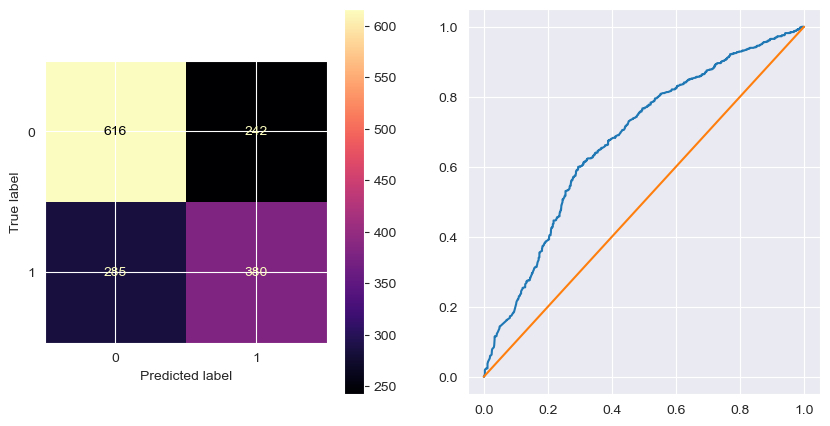

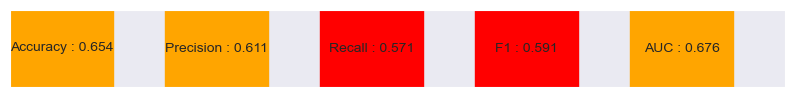

In [92]:
report(TrainValidationWorkflow(
    model=LogisticRegression(),
    input_provider=InputProvider1(),
    df_train=df_train,
    df_validation=df_validation
).get_metrics_calculator())

### logistic regression with second input provider

/Users/shayan/miniconda3/envs/ML-zoomcamp-playground/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


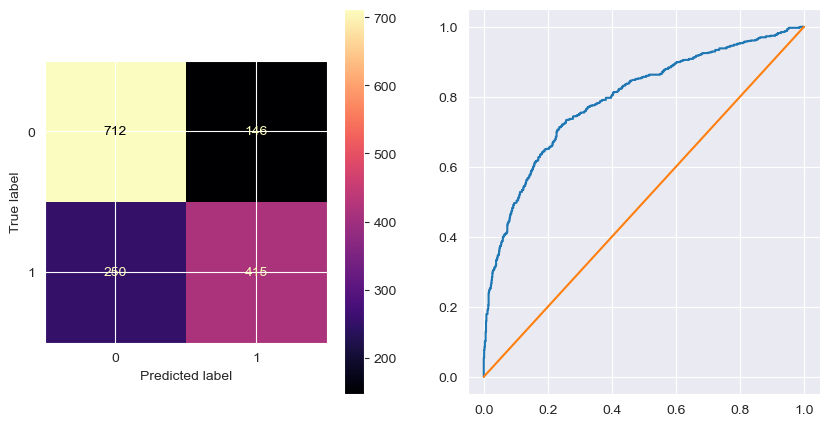

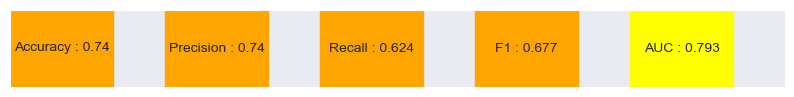

In [93]:
report(TrainValidationWorkflow(
    model=LogisticRegression(),
    input_provider=InputProvider2(),
    df_train=df_train,
    df_validation=df_validation
).get_metrics_calculator())

### Decision Tree with third input provider

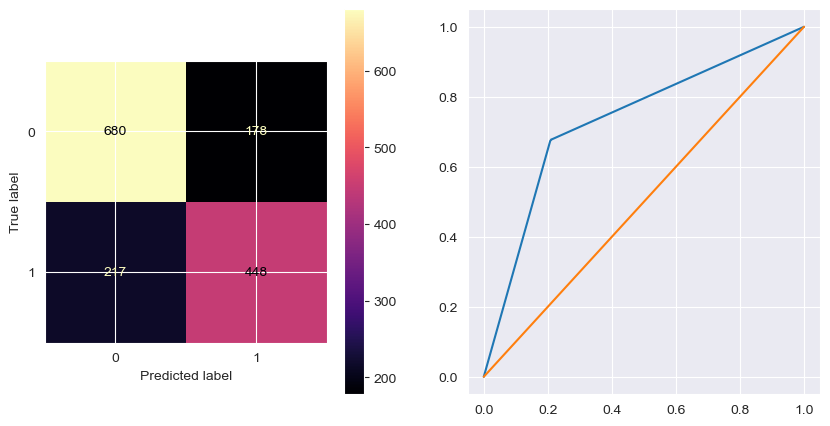

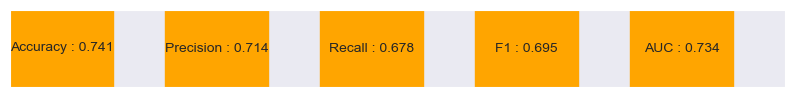

In [95]:
report(TrainValidationWorkflow(
    model=DecisionTreeClassifier(),
    input_provider=InputProvider3(),
    df_train=df_train,
    df_validation=df_validation
).get_metrics_calculator())

### Random Forest with forth input provider

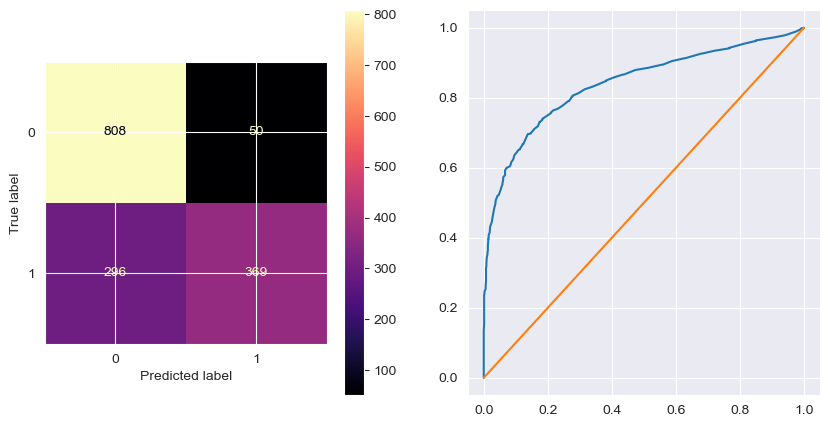

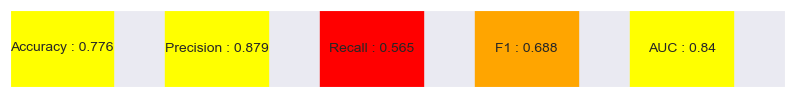

In [96]:
report(TrainValidationWorkflow(
    model=RandomForestClassifier(),
    input_provider=InputProvider4(),
    df_train=df_train,
    df_validation=df_validation
).get_metrics_calculator())

In [ ]:
### XGBoost with fifth input provider

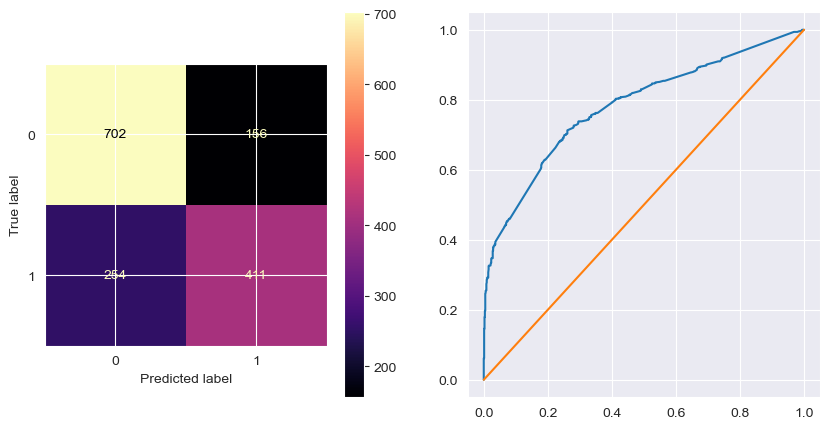

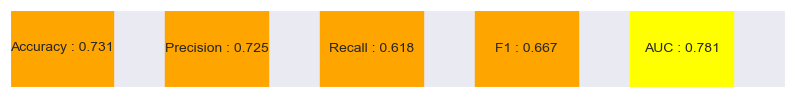

In [97]:
report(TrainValidationWorkflow(
    model=XGBoostModel(),
    input_provider=InputProvider5(),
    df_train=df_train,
    df_validation=df_validation
).get_metrics_calculator())

## All models together
lets try all models and all input providers and see their results:

In [85]:
models = [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), XGBoostModel()]
input_providers = [InputProvider1(), InputProvider2(), InputProvider3(), InputProvider4(), InputProvider5()]

performances = []
for model in models:
    for input_provider in input_providers:
        flow = TrainValidationWorkflow(model=model, input_provider=input_provider, df_train=df_train,
                                       df_validation=df_validation)
        metrics = flow.get_metrics_calculator()
        performances.append({
            'model': model.__class__.__name__,
            'input_provider': input_provider.__class__.__name__,
            'accuracy': metrics.get_accuracy(),
            'precision': metrics.get_precision(),
            'recall': metrics.get_recall(),
            'f1': metrics.get_f1(),
            'auc': metrics.get_auc(),
        })

/Users/shayan/miniconda3/envs/ML-zoomcamp-playground/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/shayan/miniconda3/envs/ML-zoomcamp-playground/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://s

In [107]:
pd.DataFrame(performances)

,model,input_provider,accuracy,precision,recall,f1,auc
0,LogisticRegression,InputProvider1,0.653972,0.610932,0.571429,0.590521,0.676447
1,LogisticRegression,InputProvider2,0.739987,0.739750,0.624060,0.676998,0.793201
2,LogisticRegression,InputProvider3,0.785292,0.796491,0.682707,0.735223,0.846751
3,LogisticRegression,InputProvider4,0.798424,0.803390,0.712782,0.755378,0.851936
4,LogisticRegression,InputProvider5,0.793171,0.795608,0.708271,0.749403,0.854789
5,DecisionTreeClassifier,InputProvider1,0.579777,0.516961,0.572932,0.543509,0.596384
6,DecisionTreeClassifier,InputProvider2,0.665135,0.628524,0.569925,0.597792,0.654814
7,DecisionTreeClassifier,InputProvider3,0.754432,0.732800,0.688722,0.710078,0.747479
8,DecisionTreeClassifier,InputProvider4,0.717006,0.714286,0.586466,0.644096,0.702597
9,DecisionTreeClassifier,InputProvider5,0.719632,0.722015,0.581955,0.644463,0.704434


the best AUC was achieved with running logistic regression with 5th input provider.
the best precision was achieved with running random forest with 4th input provider.
all other metrics were best in logistic regression with 4th input provider.

all these models were trained with their default parameters. we need to tune their hyperparameters in order to get better result